In [1]:
from selenium import webdriver
from time import sleep
import time
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import StaleElementReferenceException, TimeoutException, NoSuchElementException, ElementClickInterceptedException
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from scipy.special import softmax
import base64
from io import BytesIO
from flask import Flask, render_template, request
import re
from wordcloud import WordCloud

In [2]:
'''app = Flask(__name__)
@app.route('/', methods=['GET', 'POST'])
def index():
    result = None
    if request.method == 'POST':
        link = request.form.get('link')
        if link:
            action = request.form.get('action')
            if action == 'fast':
                overall_sentiment, plot_base64 = fastbutton(link)
                result = {
                    'overall_sentiment': overall_sentiment,
                    'plot_base64': plot_base64
                }
            elif action == 'slow':
                overall_sentiment, plot_base64 = slowbutton(link)
                result = {
                    'overall_sentiment': overall_sentiment,
                    'plot_base64': plot_base64
                }
    return render_template('index.html', result=result)

if __name__ == '__main__':
    app.run(debug=True)'''

"app = Flask(__name__)\n@app.route('/', methods=['GET', 'POST'])\ndef index():\n    result = None\n    if request.method == 'POST':\n        link = request.form.get('link')\n        if link:\n            action = request.form.get('action')\n            if action == 'fast':\n                overall_sentiment, plot_base64 = fastbutton(link)\n                result = {\n                    'overall_sentiment': overall_sentiment,\n                    'plot_base64': plot_base64\n                }\n            elif action == 'slow':\n                overall_sentiment, plot_base64 = slowbutton(link)\n                result = {\n                    'overall_sentiment': overall_sentiment,\n                    'plot_base64': plot_base64\n                }\n    return render_template('index.html', result=result)\n\nif __name__ == '__main__':\n    app.run(debug=True)"

In [3]:
#collecting reviews
def data(pl):
    path_to_chromedriver = r"C:\Path\To\chromedriver.exe"
    chrome_binary_path = r"C:\Drivers\chrome-win64\chrome.exe"
    chrome_options = webdriver.ChromeOptions()
    chrome_options.binary_location = chrome_binary_path
    chrome_options.add_argument('executable_path=' + path_to_chromedriver)
    #opening browser and link
    browser = webdriver.Chrome(options=chrome_options)
    browser.get(pl)
    browser.maximize_window()
    #finding all reviews
    mydiv = browser.find_element(By.CLASS_NAME, '_3UAT2v._16PBlm')
    parent = mydiv.find_element(By.XPATH, '..')
    reviewlink = parent.get_attribute('href')
    browser.get(reviewlink)#opened all reviews
    
    #scraping, sorting fake and small reviews into a df
    reviews = []
    i=0
    while True:
        try:
            if i == 0:
                review = browser.find_elements(By.CLASS_NAME,'t-ZTKy')
                for r in review:
                    rt = r.text
                    if len(rt.split()) > 2:
                        rt= re.sub(r'[^a-zA-Z0-9\s\.,!?]', '', rt)
                        reviews.append(rt)
                    nextreviewpage = browser.find_element(By.CLASS_NAME,"_1LKTO3")
                nextreviewpage = nextreviewpage.get_attribute('href')
                browser.get(nextreviewpage)
                i+=1
            
            if browser.find_element(By.CLASS_NAME,"_1LKTO3"):
                i+=1
                review = browser.find_elements(By.CLASS_NAME,'t-ZTKy')
                for r in review:
                    rt = r.text
                    if len(rt.split()) > 2:
                        rt= re.sub(r'[^a-zA-Z0-9\s\.,!?]', '', rt)
                        reviews.append(rt)
                nextreviewpages=[]
                nextreviewpage = browser.find_elements(By.CLASS_NAME,"_1LKTO3")
                for review in nextreviewpage:
                    review = review.get_attribute('href')
                    nextreviewpages.append(review)
                if len(nextreviewpages)>1:
                    browser.get(nextreviewpages[1])
                else:
                    review = browser.find_elements(By.CLASS_NAME,'t-ZTKy')
                    for r in review:
                        rt = r.text
                        if len(rt.split()) > 2:
                            rt= re.sub(r'[^a-zA-Z0-9\s\.,!?]', '', rt)
                            reviews.append(rt)
                    print(len(reviews), "Reviews extracted")
                    break
        except (StaleElementReferenceException, ElementClickInterceptedException, TimeoutException, NoSuchElementException):
            break
    reviewsdf = pd.DataFrame(reviews, columns=["Reviews"])
    return reviewsdf

In [4]:
'''def word_cloud(df):
    all_words = ' '.join([txt for txt in df])
    wordcloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(all_words)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    
    # Convert the plot to a base64-encoded image
    plot_base641 = base64.b64encode(buffer.read()).decode('utf-8')
    
    return plot_base641'''

"def word_cloud(df):\n    all_words = ' '.join([txt for txt in df])\n    wordcloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(all_words)\n    plt.imshow(wordcloud, interpolation = 'bilinear')\n    plt.axis('off')\n    \n    buffer = BytesIO()\n    plt.savefig(buffer, format='png')\n    buffer.seek(0)\n    \n    # Convert the plot to a base64-encoded image\n    plot_base641 = base64.b64encode(buffer.read()).decode('utf-8')\n    \n    return plot_base641"

In [5]:
def polarity_scores_roberta(df):
    MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

    encoded_text = tokenizer(df, return_tensors='tf')
    output = model(**encoded_text)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [6]:
def robertaslow(df):
    df = df.reset_index().rename(columns={'index':'ID'})
    results = []
    res = {}
    for i in range(len(df)):
        res[df['ID'][i]]= polarity_scores_roberta(df['Reviews'][i])
    results = pd.DataFrame(res).T
    results = results.reset_index().rename(columns={'index':'ID'})
    results = results.merge(df, how='left')
    return results

In [7]:
def slowbutton(pl):
    strl = str(pl)
    df = data(strl)
    word_cloud(df)
    resultsf = robertaslow(df)
    total_pos = resultsf['roberta_pos'].sum()
    total_neg = resultsf['roberta_neg'].sum()
    total_neu = resultsf['roberta_neu'].sum()

    if total_pos > total_neg and total_pos > total_neu:
        overall_sentiment = 'Positive'
    elif total_neg > total_pos and total_neg > total_neu:
        overall_sentiment = 'Negative'
    else:
        overall_sentiment = 'Neutral'

    #print(f"Overall sentiment for the product: {overall_sentiment}")
    
    sentiments = ['Positive', 'Neutral', 'Negative']
    scores = [total_pos, total_neu, total_neg]
    
    plt.bar(sentiments, scores, color=['green', 'gray', 'red'])
    plt.xlabel('Sentiment')
    plt.ylabel('Aggregated Score')
    plt.title('Overall Sentiment Analysis for the Product')
   
    # Save the plot to a BytesIO buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    
    # Convert the plot to a base64-encoded image
    plot_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    
    return overall_sentiment, plot_base64

In [8]:
def sentifast(df):
    senti = pipeline("sentiment-analysis")
    df = df.reset_index().rename(columns={'index':'ID'})
    ress = {}
    results = []
    for i in range(len(df)):
        ress[df['ID'][i]]= senti(df['Reviews'][i])
    flat_data = [item[0] for item in ress.values()]
    results= pd.DataFrame(flat_data)
    results = pd.DataFrame(results)
    results = results.reset_index().rename(columns={'index':'ID'})
    results = results.merge(df, how='right')
    return results

In [9]:
def fastbutton(pl):
    strl = str(pl)
    df = data(strl)
    #word = word_cloud(df)
    resultsf = sentifast(df)
    total_pos = 0
    total_neg = 0
    for i in range(len(resultsf)):
        if resultsf['label'][i] == "POSITIVE":
            total_pos += resultsf['score'][i]
        else:
            total_neg += resultsf['score'][i]
    if total_neg > total_pos:
        overall_sentiment = 'Negative'
    else:
        overall_sentiment = 'Positive'
    #print(f"Overall sentiment for the product: {overall_sentiment}")
    sentiments = ['Positive', 'Negative']
    scores = [total_pos, total_neg]
    plt.bar(sentiments, scores, color=['green', 'red'])
    plt.xlabel('Sentiment')
    plt.ylabel('Aggregated Score')
    plt.title('Overall Sentiment Analysis for the Product')

    # Save the plot to a BytesIO buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    
    # Convert the plot to a base64-encoded image
    plot_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    
    return overall_sentiment, plot_base64

203 Reviews extracted


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.0.1)
    Python  3.11.4 (you have 3.11.4)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


NameError: name 'word' is not defined

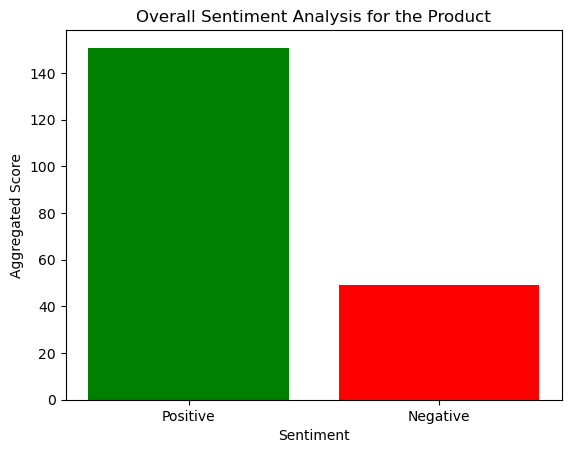

In [10]:
fastbutton('https://www.flipkart.com/lenovo-23-8-inch-full-hd-va-panel-3-side-near-edgeless-tuv-eye-care-monitor-d24-20/p/itm8f8c6bfc86fb5?pid=MONFV5HRNF4QFVG4&lid=LSTMONFV5HRNF4QFVG4ATFEMN&marketplace=FLIPKART&store=6bo%2Fg0i%2F9no&srno=b_1_5&otracker=browse&otracker1=hp_rich_navigation_PINNED_neo%2Fmerchandising_NA_NAV_EXPANDABLE_navigationCard_cc_3_L2_view-all&fm=organic&iid=f6810f2e-df99-4107-9b26-8c4b59a9a694.MONFV5HRNF4QFVG4.SEARCH&ppt=hp&ppn=homepage&ssid=qvynpv4jpc0000001693079777287')